In [1]:
import joblib
import pandas as pd

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt

In [2]:
# Import data
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/y_test.csv')

In [3]:
# Create Function Transformer to use Feature Union
def get_numeric_data(x):
    return x.drop(['review','review_processed','review_processed_stop'],axis=1)

def get_text_data(x):
    return x['review_processed']

transformer_numeric = FunctionTransformer(get_numeric_data)
transformer_text = FunctionTransformer(get_text_data)

In [4]:
# Function to return metrics
def model_metrics(y_pred, y_pred_proba):
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1:', f1_score(y_test, y_pred, average='macro'))
    print('ROC_AUC:', roc_auc_score(y_test, y_pred_proba))

    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, y_pred))

    print('\nClassification Report:')
    print(classification_report(y_test, y_pred))

# Logistic Regression

In [5]:
# Load file
logreg = joblib.load('models/logreg.pkl')

In [6]:
# Model prediction
y_pred_logreg = logreg.predict(X_test)
y_pred_logreg_proba = logreg.predict_proba(X_test)[:, 1]

In [7]:
# Evaluation
model_metrics(y_pred_logreg, y_pred_logreg_proba)

Accuracy: 0.8604651162790697
Precision: 0.880354505169867
Recall: 0.9430379746835443
F1: 0.7963420051815193
ROC_AUC: 0.9095534373371748

Confusion Matrix:
[[ 251  162]
 [  72 1192]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.61      0.68       413
           1       0.88      0.94      0.91      1264

    accuracy                           0.86      1677
   macro avg       0.83      0.78      0.80      1677
weighted avg       0.85      0.86      0.85      1677



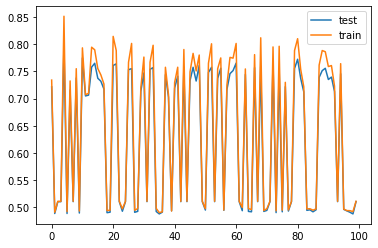

In [8]:
# Plot train and test F1 scores curves
test_scores_logreg = logreg.cv_results_['mean_test_F1']
train_scores_logreg = logreg.cv_results_['mean_train_F1']
plt.plot(test_scores_logreg, label='test')
plt.plot(train_scores_logreg, label='train')
plt.legend(loc='best')
plt.show()

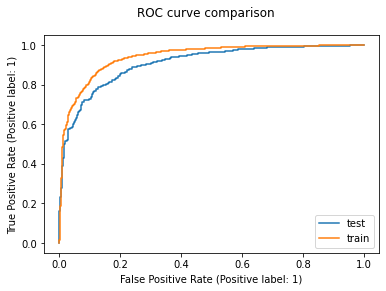

In [9]:
# Plot ROC curve for train and test dataset
ax = plt.gca()
roc_test_logreg = plot_roc_curve(logreg, X_test,y_test, ax=ax)
roc_train_logreg = plot_roc_curve(logreg,X_train,y_train, ax=ax)
roc_train_logreg.figure_.suptitle("ROC curve comparison")
ax.legend(labels=['test','train'])
plt.show()

# SVM

In [10]:
# Load file
svm = joblib.load('models/svm.pkl')

In [11]:
# Model prediction
y_pred_svm = svm.predict(X_test)
y_pred_svm_proba = svm.predict_proba(X_test)[:, 1]

In [12]:
# Evaluation
model_metrics(y_pred_svm, y_pred_svm_proba)

Accuracy: 0.8425760286225402
Precision: 0.8654970760233918
Recall: 0.9367088607594937
F1: 0.7670225395515665
ROC_AUC: 0.8754712354798173

Confusion Matrix:
[[ 229  184]
 [  80 1184]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.55      0.63       413
           1       0.87      0.94      0.90      1264

    accuracy                           0.84      1677
   macro avg       0.80      0.75      0.77      1677
weighted avg       0.83      0.84      0.83      1677



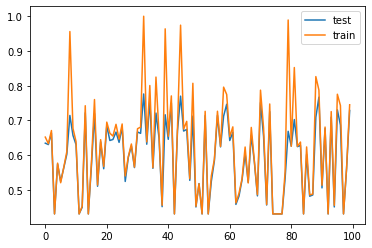

In [13]:
# Plot train and test F1 scores curves
test_scores_svm = svm.cv_results_['mean_test_F1']
train_scores_svm = svm.cv_results_['mean_train_F1'] 
plt.plot(test_scores_svm, label='test')
plt.plot(train_scores_svm, label='train')
plt.legend(loc='best')
plt.show()

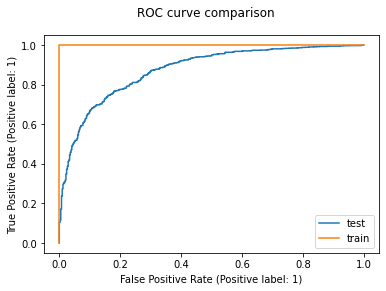

In [14]:
# Plot ROC curve for train and test dataset
ax = plt.gca()
roc_test_svm = plot_roc_curve(svm, X_test,y_test, ax=ax)
roc_train_svm = plot_roc_curve(svm, X_train,y_train, ax=ax)
roc_train_svm.figure_.suptitle("ROC curve comparison")
ax.legend(labels=['test','train'])
plt.show()

# Naive Bayes

In [15]:
# Load file
nb = joblib.load('models/nb.pkl')

In [16]:
# Model prediction
y_pred_nb = nb.predict(X_test)
y_pred_nb_proba = nb.predict_proba(X_test)[:, 1]

In [17]:
# Evaluation
model_metrics(y_pred_nb, y_pred_nb_proba)

Accuracy: 0.8258795468097794
Precision: 0.824
Recall: 0.9778481012658228
F1: 0.6997203757757119
ROC_AUC: 0.8625927146228584

Confusion Matrix:
[[ 149  264]
 [  28 1236]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.36      0.51       413
           1       0.82      0.98      0.89      1264

    accuracy                           0.83      1677
   macro avg       0.83      0.67      0.70      1677
weighted avg       0.83      0.83      0.80      1677



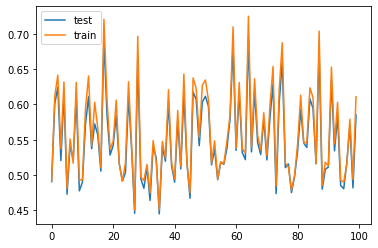

In [18]:
# Plot train and test F1 scores curves
test_scores_nb = nb.cv_results_['mean_test_F1']
train_scores_nb = nb.cv_results_['mean_train_F1'] 
plt.plot(test_scores_nb, label='test')
plt.plot(train_scores_nb, label='train')
plt.legend(loc='best')
plt.show()

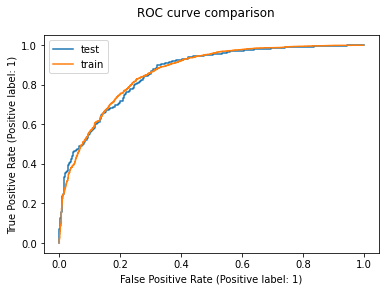

In [19]:
# Plot ROC curve for train and test dataset
ax = plt.gca()
roc_test_nb = plot_roc_curve(nb, X_test,y_test, ax=ax)
roc_train_nb = plot_roc_curve(nb, X_train,y_train, ax=ax)
roc_train_nb.figure_.suptitle("ROC curve comparison")
ax.legend(labels=['test','train'])
plt.show()

# Stacking

In [20]:
# Predictions for train datasets and convert to dataframe
y_pred_logreg_train = pd.DataFrame(logreg.predict(X_train))
y_pred_svm_train = pd.DataFrame(svm.predict(X_train))
y_pred_nb_train = pd.DataFrame(nb.predict(X_train))

# Convert test datasets into dataframe
y_pred_logreg = pd.DataFrame(y_pred_logreg)
y_pred_svm = pd.DataFrame(y_pred_svm)
y_pred_nb = pd.DataFrame(y_pred_nb)

In [21]:
# Concatenate the predictions for both train and test datasets for all 3 models
df_train = pd.concat([y_pred_logreg_train, y_pred_svm_train, y_pred_nb_train],axis=1)
df_test = pd.concat([y_pred_logreg, y_pred_svm, y_pred_nb], axis=1)

In [22]:
# Load file
stack_model = joblib.load('models/stack_model.pkl')

In [23]:
# Model prediction
y_pred_stack = stack_model.predict(df_test)
y_pred_stack_proba = stack_model.predict_proba(df_test)[:, 1]

In [24]:
# Evaluation
model_metrics(y_pred_stack, y_pred_stack_proba)

Accuracy: 0.8425760286225402
Precision: 0.8654970760233918
Recall: 0.9367088607594937
F1: 0.7670225395515665
ROC_AUC: 0.7455941398228462

Confusion Matrix:
[[ 229  184]
 [  80 1184]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.55      0.63       413
           1       0.87      0.94      0.90      1264

    accuracy                           0.84      1677
   macro avg       0.80      0.75      0.77      1677
weighted avg       0.83      0.84      0.83      1677



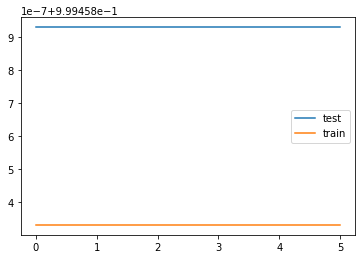

In [25]:
# Plot train and test F1 scores curves
test_scores_stack_model = stack_model.cv_results_['mean_test_F1']
train_scores_stack_model = stack_model.cv_results_['mean_train_F1'] 
plt.plot(test_scores_stack_model, label='test')
plt.plot(train_scores_stack_model, label='train')
plt.legend(loc='best')
plt.show()

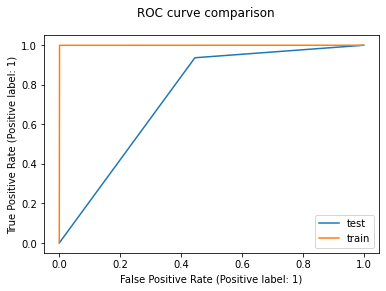

In [26]:
# Plot ROC curve for train and test dataset
ax = plt.gca()
roc_test_stack_model = plot_roc_curve(stack_model, df_test,y_test, ax=ax)
roc_train_stack_model = plot_roc_curve(stack_model, df_train,y_train, ax=ax)
roc_train_stack_model.figure_.suptitle("ROC curve comparison")
ax.legend(labels=['test','train'])
plt.show()

# Bagging (Logistic Regression)

In [19]:
# Load file
logreg_bagging = joblib.load('models/logreg_bagging.pkl')
X_test_combined = pd.read_csv('data/X_test_vectorized_logreg.csv')

In [20]:
# Model prediction
y_pred_logreg_bagging = logreg_bagging.predict(X_test_combined)
y_pred_logreg_bagging_proba = logreg_bagging.predict_proba(X_test_combined)[:, 1]

In [21]:
# Evaluation
model_metrics(y_pred_logreg_bagging, y_pred_logreg_bagging_proba)

Accuracy: 0.8598688133571855
Precision: 0.8646350106307583
Recall: 0.9651898734177216
F1: 0.7830261654714878
ROC_AUC: 0.9191486345664633

Confusion Matrix:
[[ 222  191]
 [  44 1220]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.54      0.65       413
           1       0.86      0.97      0.91      1264

    accuracy                           0.86      1677
   macro avg       0.85      0.75      0.78      1677
weighted avg       0.86      0.86      0.85      1677



# Bagging (SVM)

In [ ]:
import zipfile
with zipfile.ZipFile('models/svm_bagging.pkl.zip', 'r') as zip_ref:
    zip_ref.extractall('models/')

In [23]:
# Load file
svm_bagging = joblib.load('models/svm_bagging.pkl')
X_test_combined = pd.read_csv('data/X_test_vectorized_svm.csv')

In [24]:
# Model prediction
y_pred_svm_bagging = svm_bagging.predict(X_test_combined)
y_pred_svm_bagging_proba = svm_bagging.predict_proba(X_test_combined)[:, 1]

In [25]:
# Evaluation
model_metrics(y_pred_svm_bagging, y_pred_svm_bagging_proba)

Accuracy: 0.83840190816935
Precision: 0.8384458077709611
Recall: 0.9731012658227848
F1: 0.7328884873925379
ROC_AUC: 0.9056341373708892

Confusion Matrix:
[[ 176  237]
 [  34 1230]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.43      0.57       413
           1       0.84      0.97      0.90      1264

    accuracy                           0.84      1677
   macro avg       0.84      0.70      0.73      1677
weighted avg       0.84      0.84      0.82      1677



# Bagging (Naive Bayes)

In [26]:
# Load file
nb_bagging = joblib.load('models/nb_bagging.pkl')
X_test_combined = pd.read_csv('data/X_test_vectorized_nb.csv')

In [27]:
# Model prediction
y_pred_nb_bagging = nb_bagging.predict(X_test_combined)
y_pred_nb_bagging_proba = nb_bagging.predict_proba(X_test_combined)[:, 1]

In [28]:
# Evaluation
model_metrics(y_pred_nb_bagging, y_pred_nb_bagging_proba)

Accuracy: 0.789505068574836
Precision: 0.784154709918902
Recall: 0.9944620253164557
F1: 0.5760143930544345
ROC_AUC: 0.8963530971281455

Confusion Matrix:
[[  67  346]
 [   7 1257]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.16      0.28       413
           1       0.78      0.99      0.88      1264

    accuracy                           0.79      1677
   macro avg       0.84      0.58      0.58      1677
weighted avg       0.81      0.79      0.73      1677



# Boosting (keep / remove depending on Model Building notebook)

In [31]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [32]:
# Import files
X_train_combined = pd.read_csv('data/X_train_vectorized.csv')
X_test_combined = pd.read_csv('data/X_test_vectorized.csv')

In [33]:
# RandomForest
clf = RandomForestClassifier(n_estimators=100, max_features="auto",random_state=0)
clf.fit(X_train_combined, y_train)
y_pred = clf.predict(X_test_combined)
model_metrics(y_test, y_pred)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
ROC_AUC: 0.6667340316302449

Confusion Matrix:
[[ 413    0]
 [   0 1264]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       413
           1       1.00      1.00      1.00      1264

    accuracy                           1.00      1677
   macro avg       1.00      1.00      1.00      1677
weighted avg       1.00      1.00      1.00      1677



In [34]:
# AdaBoost
clf = AdaBoostClassifier(n_estimators=100)
clf.fit(X_train_combined, y_train)
y_pred = clf.predict(X_test_combined)
model_metrics(y_test, y_pred)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
ROC_AUC: 0.7165020535139609

Confusion Matrix:
[[ 413    0]
 [   0 1264]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       413
           1       1.00      1.00      1.00      1264

    accuracy                           1.00      1677
   macro avg       1.00      1.00      1.00      1677
weighted avg       1.00      1.00      1.00      1677



In [35]:
# GradientBoosting
clf = GradientBoostingClassifier(n_estimators=100)
clf.fit(X_train_combined, y_train)
y_pred = clf.predict(X_test_combined)
model_metrics(y_test, y_pred)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
ROC_AUC: 0.6813097664510988

Confusion Matrix:
[[ 413    0]
 [   0 1264]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       413
           1       1.00      1.00      1.00      1264

    accuracy                           1.00      1677
   macro avg       1.00      1.00      1.00      1677
weighted avg       1.00      1.00      1.00      1677

